# General data reader for AQUA 
## Spatial regridding

The reader includes also regridding functionality. The idea of the regridder (which uses sparse matrix multiplication) is to generate first the weights for the interpolation (an operation which needs to be done only once) and then to use them for each regridding operation.

The regridding weights are generated automatically by the reader if not already existant and stored in a directory specified in the `config/machines/<machine-name>/regrid.yaml` file, where machine is levante. The same file also contains a list of predefined target grids (only regular lon-lat for now). For example "r100" is a regular grid at 1° resolution.

CDO is used for generating the weights and it will be needed in your environment. CDO is not needed to use the regridder, only to generate the weights. The regridder configuration file also stores for now (this may be modified in the future) information on files containing a grid description for different data sources. 

For regridding to work you will need the external [smmregrid](https://github.com/jhardenberg/smmregrid) module.

In [1]:
from aqua import Reader

### Example 1: IFS

We load IFS data specifying that we wish to regrid them to a 2° grid.

In [2]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d", regrid="r200")
data = reader.retrieve(fix=False)

by default, the data are still on the raw original grid. Let's look at temperature

In [3]:
data["2t"][1,:]

<xarray.DataArray '2t' (value: 26306560)>
dask.array<getitem, shape=(26306560,), dtype=float64, chunksize=(26306560,), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    time     datetime64[ns] 2020-01-20T01:00:00
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

... but we can now ask to regrid it (or part of it) to the destination grid which we chose when we instantiated the reader.

In [4]:
tasr = reader.regrid(data["2t"][0:3,:])

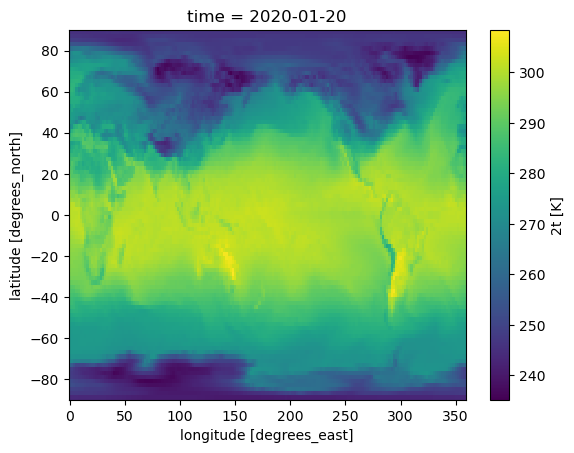

In [5]:
tasr[0,:,:].plot()

### Example 2: ICON

Instantiate a reader for ICON data specifying that we will want to interpolate to a 2 deg grid (the grids are defined in the `regrid.yaml` file and the weights saved in a special directory). If the weights file does not already exist in our collection it will be created automatically.

In [6]:
from aqua import Reader, catalogue
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09", regrid="r200")

Load the actual data. By default these data have not been regridded yet. 

You could ask to regrid them directly by specifying the argument `regrid=True` but please be warned that without a selection on dates this will take longer. It is usually more efficient to first load the data, select and then regrid.

In [7]:
data = reader.retrieve()

By default these data have not been regridded yet

In [8]:
data

<xarray.Dataset>
Dimensions:   (time: 37009, cell: 20971520)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20 ... 2022-03-01
Dimensions without coordinates: cell
Data variables: (12/33)
    cfh_lnd   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tciw      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tclw      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cptgzvi   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    mslhfl    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    msshfl    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ...        ...
    10u       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    10v       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    msntrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    mtntrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    msnsrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    mtnsrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Sapphire Dyamond (k203123) on l40687 (Linux 4.18.0-...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    history:              ./icon at 20220512 1522142023-05-18 10:12:40 retrie...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  15
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69e87...
    title:                ICON simulation
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9

Now we actually regrid part of the data (the first 96 frames)

In [9]:
t2 = reader.regrid(data['2t'][1:100,:]) 

In [10]:
t2

<xarray.DataArray '2t' (time: 99, lat: 90, lon: 180)>
dask.array<reshape, shape=(99, 90, 180), dtype=float64, chunksize=(6, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T00:30:00 ... 2020-01-22T01:30:00
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Attributes:
    cell_methods:                 t: point
    height:                       2.0 m
    long_name:                    2 metre temperature
    number_of_grid_in_reference:  1
    param:                        0.0.0
    standard_name:                tas
    units:                        K
    history:                      2023-05-18 10:12:40 variable renamed by AQU...
    paramId:                      167
    cfVarName:                    t2m
    shortName:                    2t
    regridded:                    1

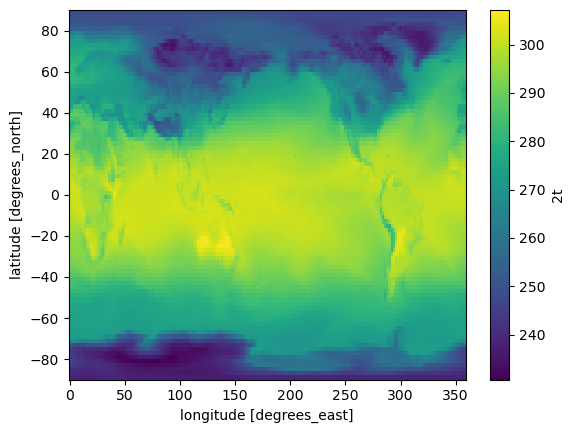

In [11]:
t2.mean("time").plot()

### Example 3: Hi-res interpolated FESOM data - with further interpolation

These are masked 3D data. For now (working on it), we can only interpolate one level at the time. So a level has to be specified and the retrieve method will only provide data from that level. An error is raised if level is not specified in this case.

In [12]:
from aqua import Reader
reader = Reader(model="FESOM", exp="tco2559-ng5", source="interpolated_global_TS", regrid="r100", level=20)

In [13]:
data = reader.retrieve()

By default these data have not been interpolated yet:

In [14]:
t = data.temp.isel(time=0)
t

<xarray.DataArray 'temp' (lat: 2700, lon: 5400)>
dask.array<getitem, shape=(2700, 5400), dtype=float32, chunksize=(900, 1800), chunktype=numpy.ndarray>
Coordinates:
    depth      float64 105.0
  * lat        (lat) float64 -90.0 -89.93 -89.87 -89.8 ... 89.8 89.87 89.93 90.0
  * lon        (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
    time       datetime64[ns] 2020-01-20T02:56:00
    latitude   (lat, lon) float64 dask.array<chunksize=(2700, 5400), meta=np.ndarray>
    longitude  (lat, lon) float64 dask.array<chunksize=(2700, 5400), meta=np.ndarray>

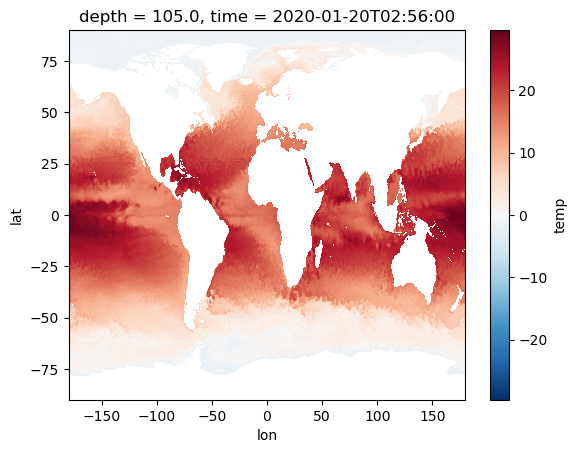

In [15]:
t.plot()

Now we actually regrid them

In [16]:
tr = reader.regrid(t)

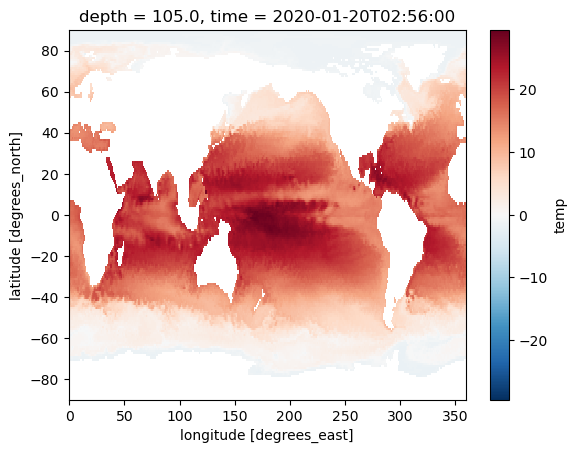

In [17]:
tr.plot()

### Example 4: Original FESOM data - further interpolation

In [18]:
from aqua import Reader
reader = Reader(model="FESOM", exp="tco2559-ng5", source="original_2d", regrid="r250")

In [19]:
data = reader.retrieve()

In [20]:
sst0=data.sst.isel(time=0)
sst0

<xarray.DataArray 'sst' (nod2: 7402886)>
dask.array<getitem, shape=(7402886,), dtype=float32, chunksize=(7402886,), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2020-01-20T00:56:00
Dimensions without coordinates: nod2
Attributes:
    description:  sea surface temperature
    long_name:    Specified sea surface temperature
    units:        K
    history:      2023-05-18 10:13:08 variable derived by AQUA fixer;\n2023-0...
    paramId:      151159
    cfVarName:    sst
    shortName:    sst
    derived:      sst
    factor:       1
    offset:       273.15
    src_units:    degC
    units_fixed:  1

sstr = reader.regrid(sst0)
sstr.plot()

### Example 5: ICON on HEALPIx

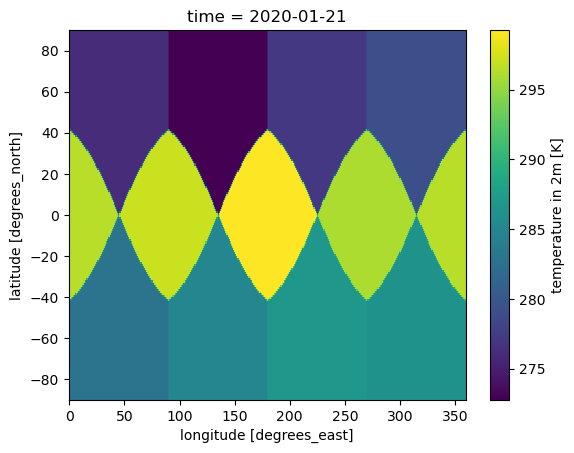

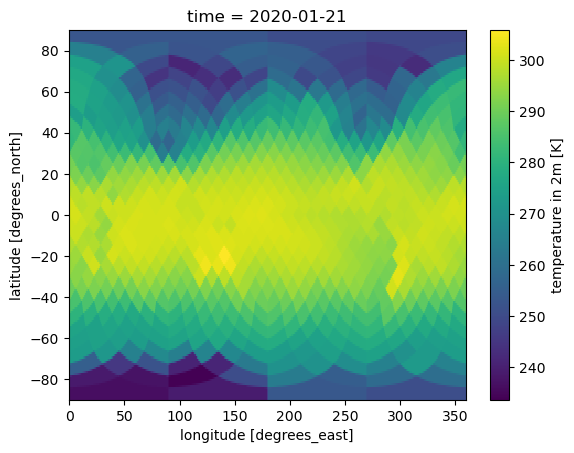

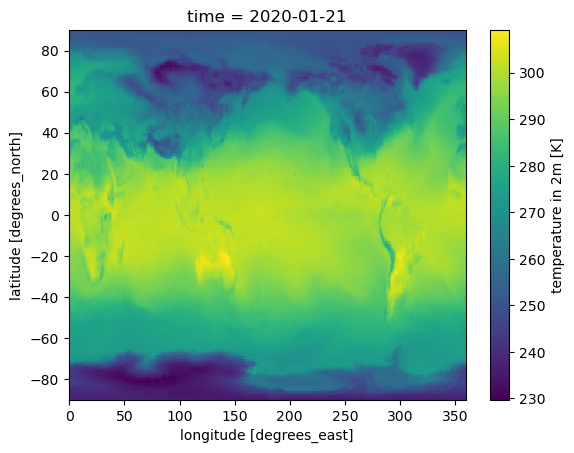

In [21]:
import matplotlib.pyplot as plt
from aqua import Reader

for zoom in [0, 3, 6]:
    reader = Reader(model="ICON", exp="ngc3028", source="P1D", zoom=zoom, regrid="r100", rebuild=True, loglevel="ERROR")
    data = reader.retrieve(fix=False)
    tas = reader.regrid(data.tas[0])
    plt.figure()
    tas.plot()